In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot

sns.set()

### set this to determine what data to process

####### NOTE !!!!! ##########
#############################
### since 2020-04-23 US states no longer work since CSSE changed their format ####
### FIXED sometime early may !#### 

#############################
#############################

US_states = True

### 
World_countries = False
### 

In [2]:
#### US STATES SPECIFIC FRAME ####

if US_states:
    
    title = 'US States'
    dick = pd.read_pickle('us_state_dict.pkl')


    states_timeline = pd.DataFrame()
    for state,timeline in dick.items():
        temp = pd.DataFrame(data=timeline,index=timeline.index).reset_index()
        temp['state'] = state
        states_timeline = pd.concat([states_timeline,temp])

    states_timeline['density2'] = states_timeline['density'].copy() * -1 * np.random.lognormal(0.1,0.01) # to do test regression on itself
    states_timeline['conf_log'] = np.log10(states_timeline['confirmed'])
    states_timeline['dead_log'] = np.log10(states_timeline['deceased'])
    states_timeline['density_log'] = np.log10(states_timeline['density'])

    states_timeline.replace(np.inf,np.nan,inplace=True)
    states_timeline.dropna(inplace=True)

    states_timeline

In [3]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    us_abb = pd.read_csv('us_states.csv',sep=';',header=None,index_col=0,usecols=[0,3],names=['state','abb'])
    
if World_countries:
    world_facts = pd.read_pickle('world_facts.pkl')
    us_abb = pd.DataFrame(world_facts['abb'])
    print (world_facts)
    print (world_facts.describe())

In [4]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    df = pd.DataFrame()

    def get_latest_numbers(df,statename):
        state = dick[statename]
        last_row = pd.DataFrame(state.iloc[-1]).T
        last_row['state'] = statename
        df = pd.concat([df,last_row],axis=0)
        return df

    for key,data in dick.items():
        df = get_latest_numbers(df,key)
    
    #df.sort_values('dead_per_M',inplace=True,ascending=False)
    df.head(40)
    #df.to_pickle('US_states_latest_day.pkl')


In [5]:


us_age = pd.read_csv('us_states_age.csv',sep=r'\t',header=None,engine='python',usecols=[1,2],
                     names=['state','median_age'],index_col=0)

us_age.index = us_age.index.str.strip()
us_age

,median_age
state,
Maine,44.9
New Hampshire,43.0
Vermont,42.8
West Virginia,42.7
Florida,42.2
Puerto Rico,41.5
Connecticut,41.0
Pennsylvania,40.8
Delaware,40.7


In [6]:
if US_states:
    #us_df = pd.read_pickle('US_states_latest_day.pkl')
    us_df = df
    us_df['gdp_per_capita'] = us_df['gdp']
    us_df['density2'] = us_df['density'].copy() * -1 * np.random.lognormal(0.1,0.01) ## to test regress on itself
    us_df['conf_log'] = np.log10(us_df['confirmed'])
    us_df['dead_log'] = np.log10(us_df['deceased'])
    us_df['density_log'] = np.log10(us_df['density'])
    us_df['gdp_log'] = np.log10(us_df['gdp'])
    
    us_df.set_index('state',inplace=True)
    us_df = us_df.join(us_age)

    print(us_df)



                      confirmed  deceased     inc  dead_inc    factor  \
state                                                                   
Alabama                 26912.0     785.0   640.0      11.0  1.024361   
Alaska                    675.0      12.0    12.0       0.0  1.018100   
Arizona                 39185.0    1228.0  2341.0      25.0  1.063538   
Arkansas                13191.0     188.0   274.0       6.0  1.021212   
California             158961.0    5200.0  3235.0      86.0  1.020774   
Colorado                29427.0    1617.0   143.0      12.0  1.004883   
Connecticut             45349.0    4210.0   114.0       6.0  1.002520   
Delaware                10403.0     424.0    63.0       1.0  1.006093   
District of Columbia     9818.0     520.0    19.0       5.0  1.001939   
Florida                 80109.0    2993.0  2783.0      55.0  1.035990   
Georgia                 59078.0    2529.0   664.0      35.0  1.011367   
Hawaii                    736.0      17.0     0.0  

In [7]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    print (us_df.describe())

           confirmed      deceased          inc   dead_inc     factor  \
count      51.000000     51.000000    51.000000  51.000000  51.000000   
mean    41790.980392   2290.196078   463.588235  16.392157   1.013375   
std     62932.892460   4774.108156   767.612250  21.440222   0.013000   
min       614.000000     12.000000     0.000000   0.000000   1.000000   
25%      9231.500000    209.500000    63.000000   2.000000   1.004533   
50%     20152.000000    703.000000   246.000000   9.000000   1.008805   
75%     46806.500000   2488.000000   439.500000  22.000000   1.018317   
max    384575.000000  30909.000000  3358.000000  86.000000   1.063538   

       dead_factor       density            gdp   pct_dead    conf_per_M  \
count    51.000000     51.000000      51.000000  51.000000     51.000000   
mean      1.010617   1117.736584   64468.529412   4.120112   5941.644329   
std       0.010055   4266.295547   23600.489132   2.034954   4507.987194   
min       1.000000      3.331502   400

In [8]:

def regression(x1,x2,y):
    
    beta1_mu = pm.Uniform('beta1_mu',-0.1,0.1)
    beta1_sigma = pm.Uniform('beta1_sigma',0,0.5)
    
    beta2_mu = pm.Uniform('beta2_mu',-0.1,0.1)
    beta2_sigma = pm.Uniform('beta2_sigma',0,0.5)
    
    obs_sigma = pm.Uniform('obs_sigma',0,0.5)
    
    alpha = pm.Uniform('alpha',-1,1)
    
    beta1 = pm.Normal('beta1',beta1_mu, 1 / beta1_sigma ** 2)
    beta2 = pm.Normal('beta2',beta2_mu, 1 / beta2_sigma ** 2)
    

    if multiple_regression:
        @pm.deterministic()
        def linreq(x1=x1,x2=x2,beta1=beta1,beta2=beta2,alpha=alpha):
            return x1 * beta1 + x2*beta2 + alpha

    else:
        @pm.deterministic()
        def linreq(x1=x1,beta1=beta1,alpha=alpha):
            return x1 * beta1 + alpha
        
    obs = pm.Normal('obs',linreq,1 / obs_sigma ** 2,observed = True, value=y)
    
    if multiple_regression:
        model = pm.Model([beta1_mu,beta1_sigma,beta2_mu,beta2_sigma,obs_sigma,alpha,beta1,beta2,obs])
    else:
        model = pm.Model([beta1_mu,beta1_sigma,obs_sigma,alpha,beta1,obs])
    
    try:
        map_ = pm.MAP(model)
        map_.fit()
    except:
        print ('cant fit')
    mcmc = pm.MCMC(model)
    
    sample = mcmc.sample(100000,40000,4)
    
    beta1_mu_post = mcmc.trace('beta1_mu')[:]
    beta1_sigma_post = mcmc.trace('beta1_sigma')[:]
    
    if multiple_regression:
        beta2_mu_post = mcmc.trace('beta2_mu')[:]
        beta2_sigma_post = mcmc.trace('beta2_sigma')[:]
    
    obs_sigma_post = mcmc.trace('obs_sigma')[:]
    
    alpha_post = mcmc.trace('alpha')[:]
    
    beta1_post = mcmc.trace('beta1')[:]
    
    pmplot(beta1_post,'beta1')
    
    
    if multiple_regression:
        
        beta2_post = mcmc.trace('beta2')[:]
        
        pmplot(beta2_post,'beta2')

    
        result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                              'beta1_sigma_post' : beta1_sigma_post,
                              'beta2_mu_post' : beta2_mu_post,
                              'beta2_sigma_post' : beta2_sigma_post,
                              'obs_sigma_post' : obs_sigma_post,
                              'alpha_post' : alpha_post,
                              'beta1_post' : beta1_post,
                              'beta2_post' : beta2_post})
    
    else:
        result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                              'beta1_sigma_post' : beta1_sigma_post,
                              'obs_sigma_post' : obs_sigma_post,
                              'alpha_post' : alpha_post,
                              'beta1_post' : beta1_post})
    return result







In [9]:
#################################### HERE STARTS THE GENERIC BIT #####################################

# independent1, independent2, dependent

x1_param = x1_param_org = 'gdp_log'
x2_param = x2_param_org = 'density_log'
y_param = y_param_org = 'dead_log'

#x1_param = 'x_real'
#x2_param = 'x_spurious'
#y_param = 'y'

multiple_regression = True

outlier = 10

### REPLACE THE ASSIGNMENT TO xy BELOW WITH THE DATAFRAME YOU WANT TO RUN REGRESSION ON ###
### AND CHANGE x1_param,x2_param,y_param above to correct column names and set US_states in top frame to True/False ###

if US_states:
    xy = us_df[[x1_param,x2_param,y_param]].copy()
    title = 'US states'

if World_countries:
    xy = world_facts[[x1_param,x2_param,y_param]]
    title = 'World countries'

# THIS IS A DATASET FOR UNDERSTANDING 
if not (US_states or World_countries):
    xy = pd.read_pickle('spurious_correlation.pkl')
    
    

In [10]:
if xy.isna().any().sum():
    print ('Warning - NaN values present! DROPPING....')
    xy.dropna(inplace=True)

In [11]:
def standardize(x):
    return (x - x.mean()) / x.std()



######################################################################################################

xy[['x1_std','x2_std','y_std']] = xy.apply(standardize)

mask = (xy[['x1_std','x2_std','y_std']] > outlier).any(axis=1)

xy = (xy[~mask]).copy()

true_x1_mean = np.power(10,xy[x1_param]).mean() if ('_log' in x1_param) else xy[x1_param].mean()
true_x1_std = np.power(10,xy[x1_param]).std() if ('_log' in x1_param) else xy[x1_param].std()
true_x2_mean = np.power(10,xy[x2_param]).mean() if ('_log' in x2_param) else xy[x2_param].mean()
true_x2_std = np.power(10,xy[x2_param]).std() if ('_log' in x2_param) else xy[x2_param].std()
true_y_mean = np.power(10,xy[y_param]).mean() if ('_log' in y_param) else xy[y_param].mean()
true_y_std = np.power(10,xy[y_param]).std() if ('_log' in y_param) else xy[y_param].std()

print (xy)
print (xy.describe())

xy_orig = xy.copy()


                       gdp_log  density_log  dead_log    x1_std    x2_std  \
state                                                                       
Alabama               4.676639     2.399721  2.894870 -1.055478 -0.049936   
Alaska                4.876021     0.522640  1.079181  0.759183 -2.865645   
Arizona               4.710887     2.225910  3.089198 -0.743770 -0.310659   
Arkansas              4.648057     2.179733  2.274158 -1.315608 -0.379928   
California            4.901807     2.822170  3.716003  0.993867  0.583758   
Colorado              4.838137     2.164585  3.208710  0.414384 -0.402650   
Connecticut           4.905737     3.280098  3.624282  1.029632  1.270672   
Delaware              4.893967     3.115993  2.627366  0.922512  1.024507   
District of Columbia  5.320686     4.485715  2.716003  4.806253  3.079154   
Florida               4.713314     3.026215  3.476107 -0.721681  0.889835   
Georgia               4.770270     2.684377  3.402949 -0.203302  0.377062   

 [-----------------100%-----------------] 100000 of 100000 complete in 328.3 secPlotting beta1
Plotting beta2

result stats
       beta1_mu_post  beta1_sigma_post  beta2_mu_post  beta2_sigma_post  \
count   15000.000000      15000.000000   15000.000000      15000.000000   
mean       -0.016079          0.212677       0.016062          0.401933   
std         0.056338          0.137752       0.055814          0.069261   
min        -0.100000          0.000585      -0.099941          0.144391   
25%        -0.065778          0.095502      -0.028556          0.355869   
50%        -0.023519          0.195762       0.023083          0.414338   
75%         0.029604          0.320121       0.064472          0.458960   
max         0.099986          0.499826       0.099992          0.499980   

       obs_sigma_post    alpha_post    beta1_post    beta2_post  
count    15000.000000  15000.000000  15000.000000  15000.000000  
mean         0.492543      0.000767     -0.104384      0.699972  
st

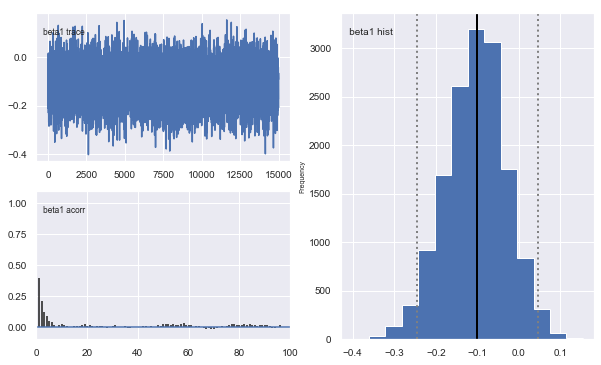

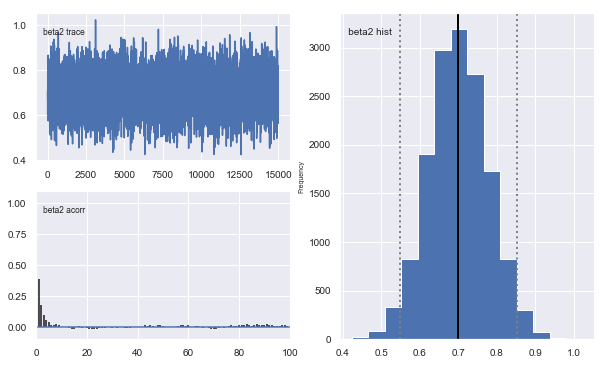

In [12]:


result = regression(xy['x1_std'],xy['x2_std'],xy['y_std'])
print ()
print ('result stats')
print (result.describe())
print()
print ('result covariance matrix')
print (result.cov())
print()
print ('result correlation coeff')
print (result.corr())

In [13]:
def plot(result,x1,x2,y,title,n,df,create_figure=True,residuals = False,color='crimson'):
    
    min_x = (np.minimum(x1,x2)).min()
    max_x = (np.maximum(x1,x2)).max()
    min_y = min(y)
    max_y = max(y)
    
    x1_mu = df[x1_param.replace('_std','')].mean()
    x1_sigma = df[x1_param.replace('_std','')].std()
    x2_mu = df[x2_param.replace('_std','')].mean()
    x2_sigma = df[x2_param.replace('_std','')].std()
    y_mu = df[y_param.replace('_std','')].mean()
    y_sigma = df[y_param.replace('_std','')].std()

    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])

    if create_figure:
        plt.figure(figsize=(18,12))
        #plt.ylim([-outlier,outlier])

    
    plt.title ('{} {}  '.format(
        n, title))

    if not residuals:
        label1 = x1_param + \
                    r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
                    x1_param_beta,alpha_param,x1_param_89[0],x1_param_89[1])
        
        if multiple_regression:
            label2 = x2_param + \
                r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
                x2_param_beta,alpha_param,x2_param_89[0],x2_param_89[1])              
    else:
        
        label1 = ' '
        
    plt.scatter(x1,y, color=color, label=label1)
    
    if multiple_regression:
        plt.scatter(x2,y,color='g',label=label2)

    X = np.linspace(min_x,max_x,1000)
    
    rows = np.random.choice(result.index,replace=True,size=len(X))

    beta1_samples = result.beta1_post[rows]

    if multiple_regression:
        beta2_samples = result.beta2_post[rows]
    
    alpha_samples = result.alpha_post[rows]

    if multiple_regression:
        lines = [X[i] * beta1_samples + X[i] * beta2_samples + alpha_samples for i in range(len (X))]
        
        
        samples2 = np.array([pm.rnormal(X[i] * result.beta1_post[rows] + X[i] * result.beta2_post[rows] + result.alpha_post[rows],
                                      1 / result.obs_sigma_post[rows] ** 2,size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.2)
        
        plt.plot(X,X * beta1_samples.mean() + X * beta2_samples.mean() + alpha_samples.mean(),color='k',ls='dashed')
        
    else:
        lines = [X[i] * beta1_samples  + alpha_samples for i in range(len (X))]
        rows = np.random.choice(result.index,replace=True,size=len(X))
        
        samples2 = np.array([pm.rnormal(X[i] * result.beta1_post[rows] + result.alpha_post[rows],
                                      1 / result.obs_sigma_post[rows] ** 2,size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.2)
        
        plt.plot(X,X * beta1_samples.mean() + alpha_samples.mean(),color='k',ls='dashed')


    plt.plot(X,lines,alpha=0.01,color='r')

    if multiple_regression:
        plt.xlabel(x1_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ] '.format(
            x1_mu,true_x1_mean,x1_sigma,true_x1_std) + \
                   x2_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ]'.format(
            x2_mu,true_x2_mean,x2_sigma,true_x2_std))
        
        if not residuals:
            plt.ylabel(y_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ]'.format(
                y_mu,true_y_mean,y_sigma,true_y_std))

    
    else:
        if not residuals:
            plt.xlabel(x1_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} '.format(x1_mu,x1_sigma) )
            plt.ylabel(y_param + r' $\mu$: {:.2f} $\sigma$: {:.2f}'.format(y_mu,y_sigma))
        else:
            plt.xlabel('predictor')
            plt.ylabel('other predictor residual')
        
    plt.legend(loc='upper left')
    
    if not multiple_regression:
        
        if US_states or World_countries:
            for s in xy.index:
                plt.text(x1.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
            
    else:
        if US_states or World_countries:
            for s in xy.index:
                plt.text(x1.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
                plt.text(x2.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
            

    filename = lambda x : x.replace(' ','_').replace('}','_').replace('{','_').replace('-','_')

    plt.savefig('linear_regression_' + filename(title) + '.jpg',format='jpg')

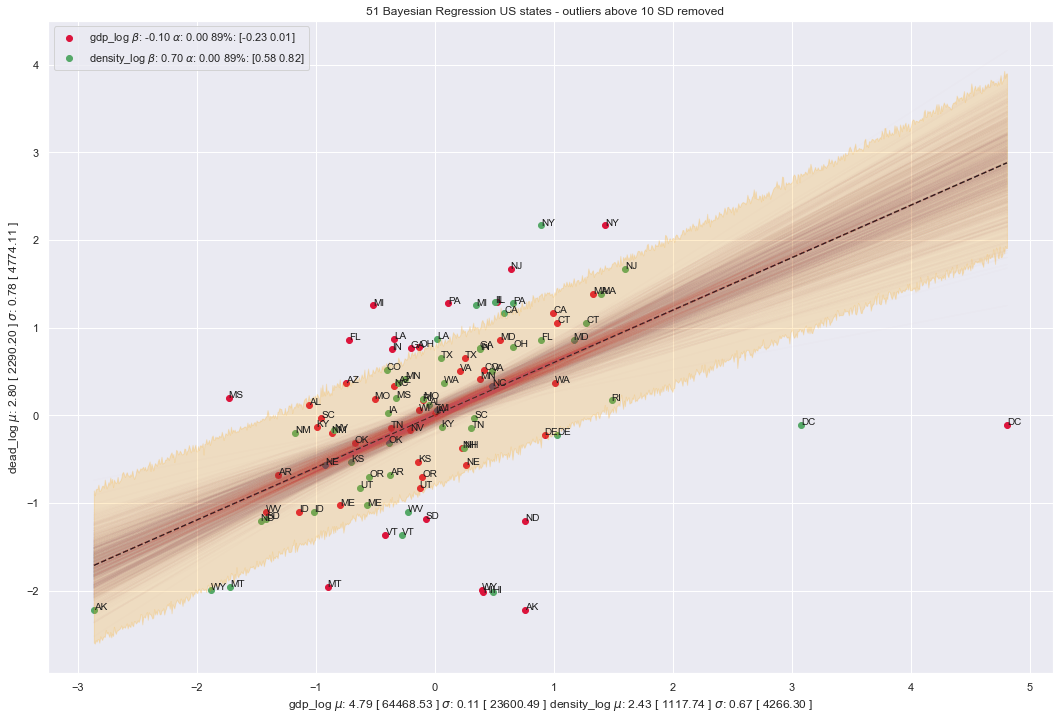

In [14]:
plot(result,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'Bayesian Regression {} - outliers above {} SD removed '.format(title, outlier),len(xy),xy)



In [15]:
print (xy.head(50))

                       gdp_log  density_log  dead_log    x1_std    x2_std  \
state                                                                       
Alabama               4.676639     2.399721  2.894870 -1.055478 -0.049936   
Alaska                4.876021     0.522640  1.079181  0.759183 -2.865645   
Arizona               4.710887     2.225910  3.089198 -0.743770 -0.310659   
Arkansas              4.648057     2.179733  2.274158 -1.315608 -0.379928   
California            4.901807     2.822170  3.716003  0.993867  0.583758   
Colorado              4.838137     2.164585  3.208710  0.414384 -0.402650   
Connecticut           4.905737     3.280098  3.624282  1.029632  1.270672   
Delaware              4.893967     3.115993  2.627366  0.922512  1.024507   
District of Columbia  5.320686     4.485715  2.716003  4.806253  3.079154   
Florida               4.713314     3.026215  3.476107 -0.721681  0.889835   
Georgia               4.770270     2.684377  3.402949 -0.203302  0.377062   

In [16]:
def plot_betas(result,title):
    
    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])
        
    plt.figure(figsize=(18,12))
    plt.title('Regression Betas ' + title)
    plt.hist(result.beta1_post,density=True,label=x1_param + \
                r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
        x1_param_beta,x1_param_sigma,x1_param_89[0],x1_param_89[1]),
             color='r',alpha=0.7,histtype='stepfilled')

    if multiple_regression:
        plt.hist(result.beta2_post,density=True,label=x2_param + \
                    r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
            x2_param_beta,x2_param_sigma,x2_param_89[0],x2_param_89[1]),
                 color='g',alpha=0.7,histtype='stepfilled')
    
    plt.legend(loc='upper left')

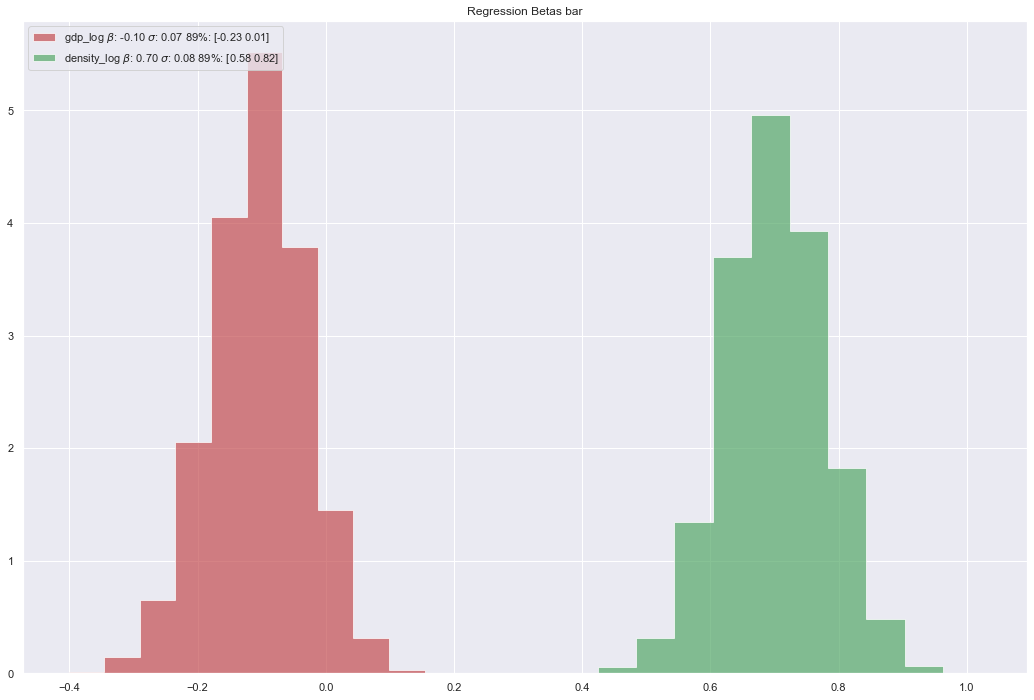

In [17]:
plot_betas(result,'bar')


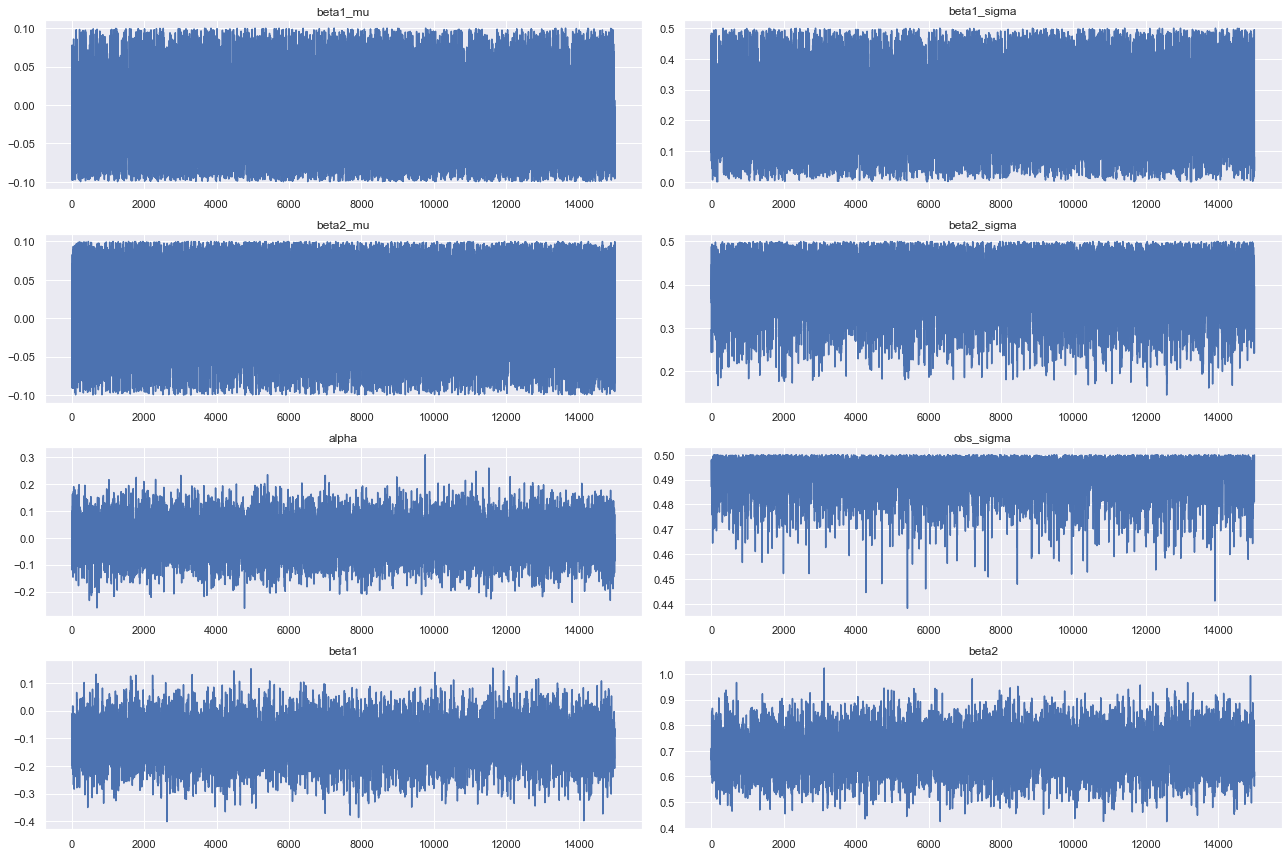

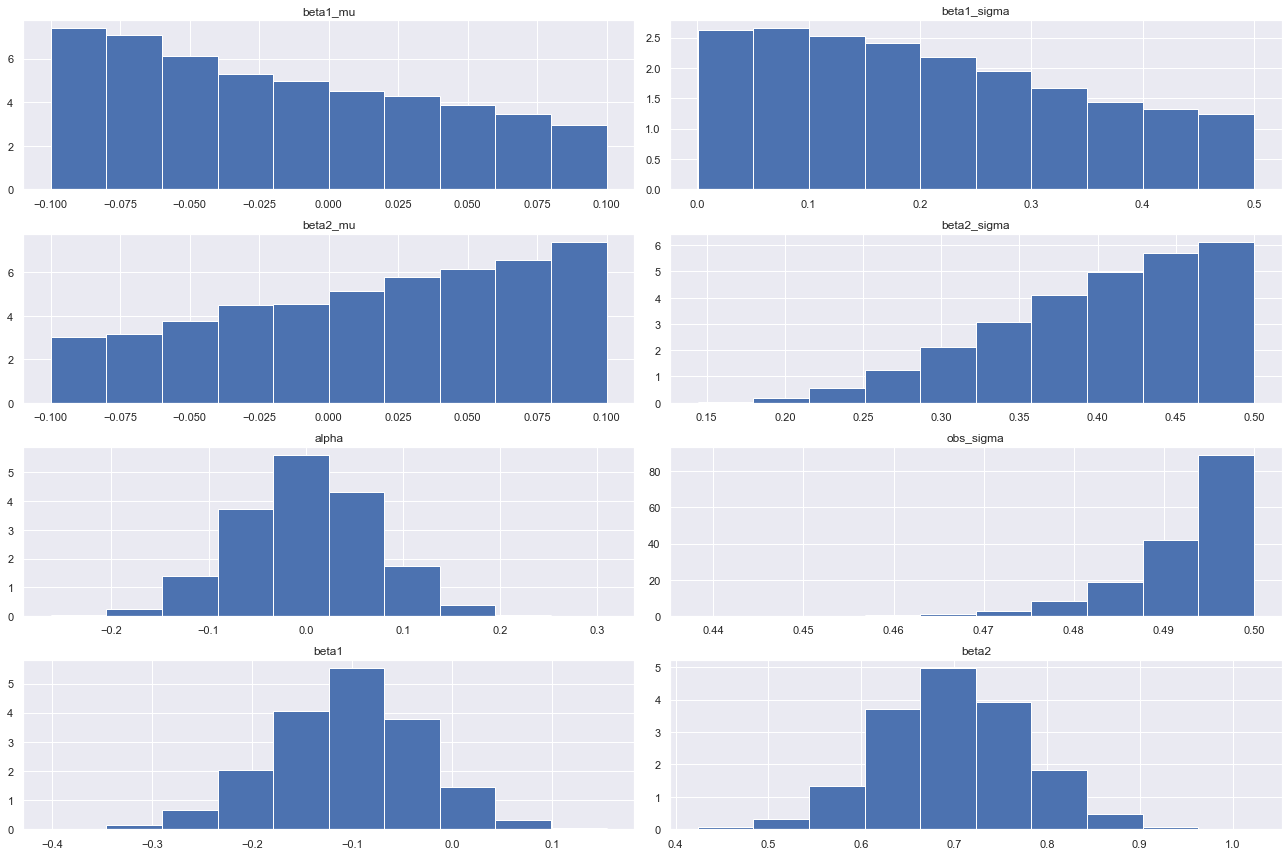

In [18]:
# disable the burn params in mcmc.sample to see the convergence
fig,axes = plt.subplots(4,2,figsize=(18,12))


axes[0,0].plot(result.beta1_mu_post)
axes[0,0].set_title('beta1_mu')
axes[0,1].plot(result.beta1_sigma_post)
axes[0,1].set_title('beta1_sigma')

if multiple_regression:
    axes[1,0].plot(result.beta2_mu_post)
    axes[1,0].set_title('beta2_mu')
    axes[1,1].plot(result.beta2_sigma_post)
    axes[1,1].set_title('beta2_sigma')
    
axes[2,0].plot(result.alpha_post)
axes[2,0].set_title('alpha')
axes[2,1].plot(result.obs_sigma_post)
axes[2,1].set_title('obs_sigma')
axes[3,0].plot(result.beta1_post)
axes[3,0].set_title('beta1')

if multiple_regression:
    axes[3,1].plot(result.beta2_post)
    axes[3,1].set_title('beta2')
    
plt.tight_layout()

fig,axes = plt.subplots(4,2,figsize=(18,12))


axes[0,0].hist(result.beta1_mu_post,density=True)
axes[0,0].set_title('beta1_mu')
axes[0,1].hist(result.beta1_sigma_post,density=True)
axes[0,1].set_title('beta1_sigma')

if multiple_regression:
    
    axes[1,0].hist(result.beta2_mu_post,density=True)
    axes[1,0].set_title('beta2_mu')
    axes[1,1].hist(result.beta2_sigma_post,density=True)
    axes[1,1].set_title('beta2_sigma')
    
axes[2,0].hist(result.alpha_post,density=True)
axes[2,0].set_title('alpha')
axes[2,1].hist(result.obs_sigma_post,density=True)
axes[2,1].set_title('obs_sigma')
axes[3,0].hist(result.beta1_post,density=True)
axes[3,0].set_title('beta1')

if multiple_regression:
    axes[3,1].hist(result.beta2_post,density=True)
    axes[3,1].set_title('beta2')
    
plt.tight_layout()

 [-----------------100%-----------------] 100000 of 100000 complete in 118.3 secPlotting beta1

                      predictor  residual
state                                    
Alabama               -1.055478  0.424770
Alaska                 0.759183 -3.206297
Arizona               -0.743770  0.023991
Arkansas              -1.315608  0.211659
California             0.993867  0.137658
Colorado               0.414384 -0.588378
Connecticut            1.029632  0.808503
Delaware               0.922512  0.610468
District of Columbia   4.806253  0.920085
Florida               -0.721681  1.214560
Georgia               -0.203302  0.468870
Hawaii                 0.406745  0.301613
Idaho                 -1.142823 -0.499152
Illinois               0.520476  0.274022
Indiana               -0.358246  0.544081
Iowa                   0.001604 -0.396847
Kansas                -0.143052 -0.637737
Kentucky              -0.993301  0.502311
Louisiana             -0.345708  0.173445
Maine                 

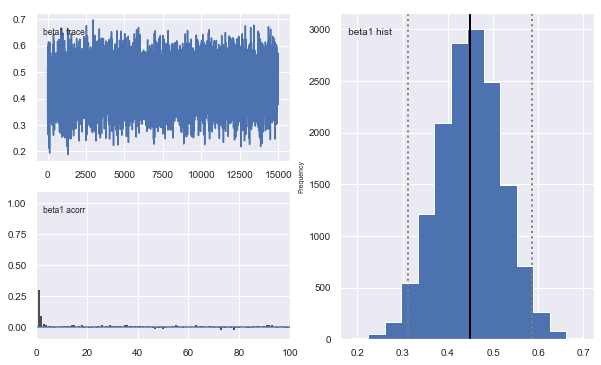

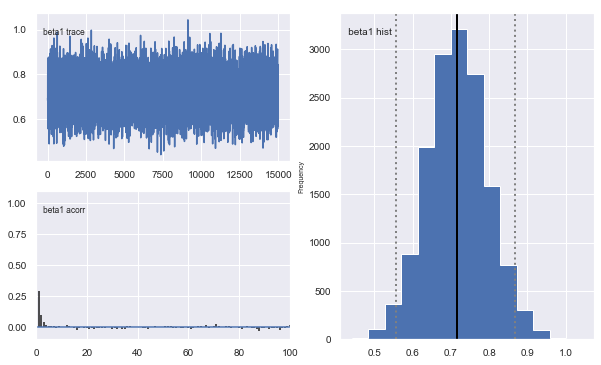

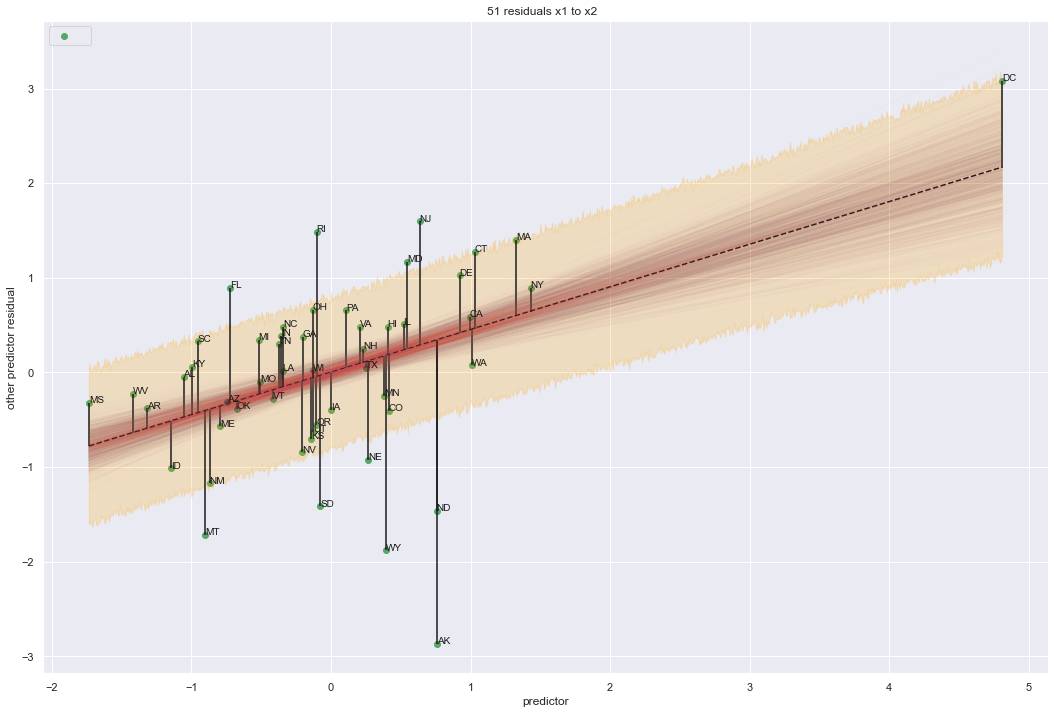

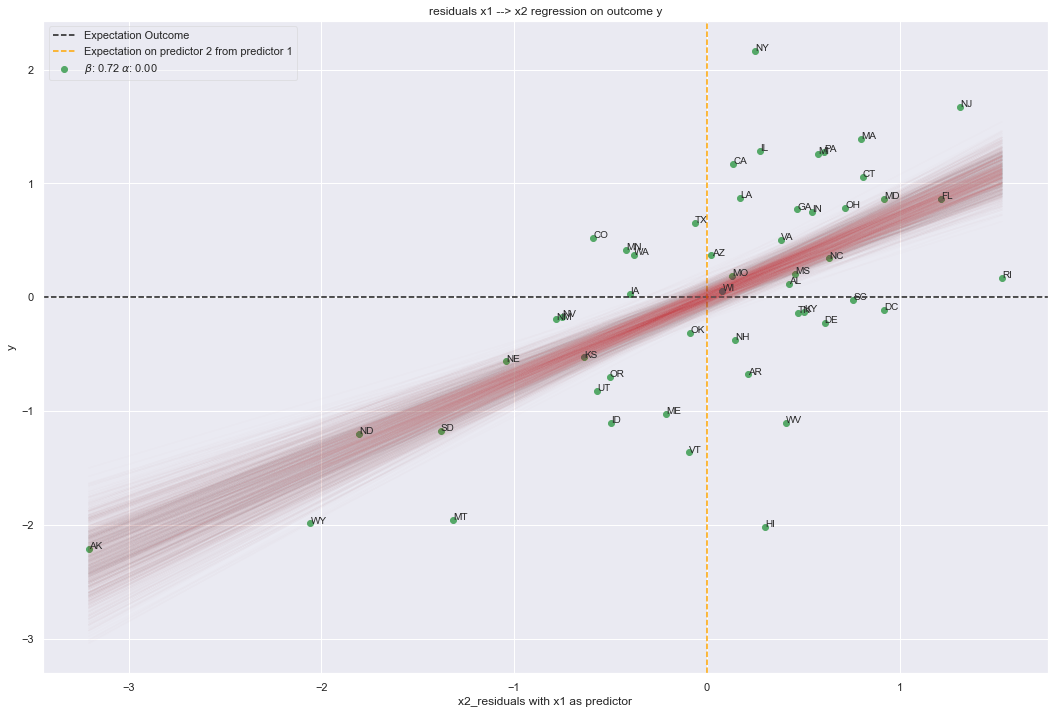

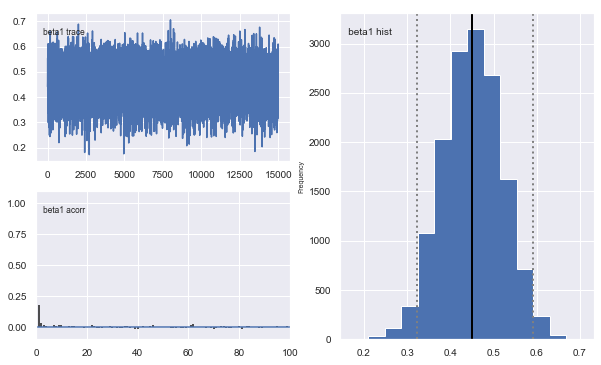

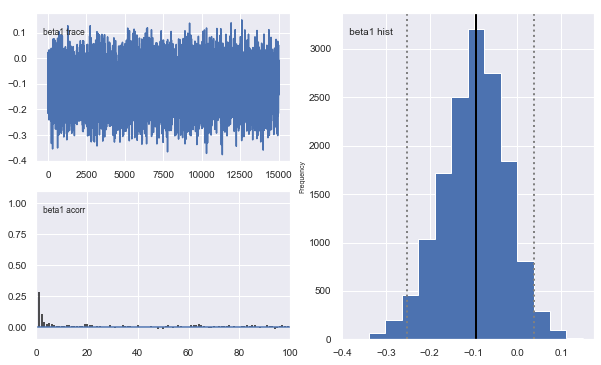

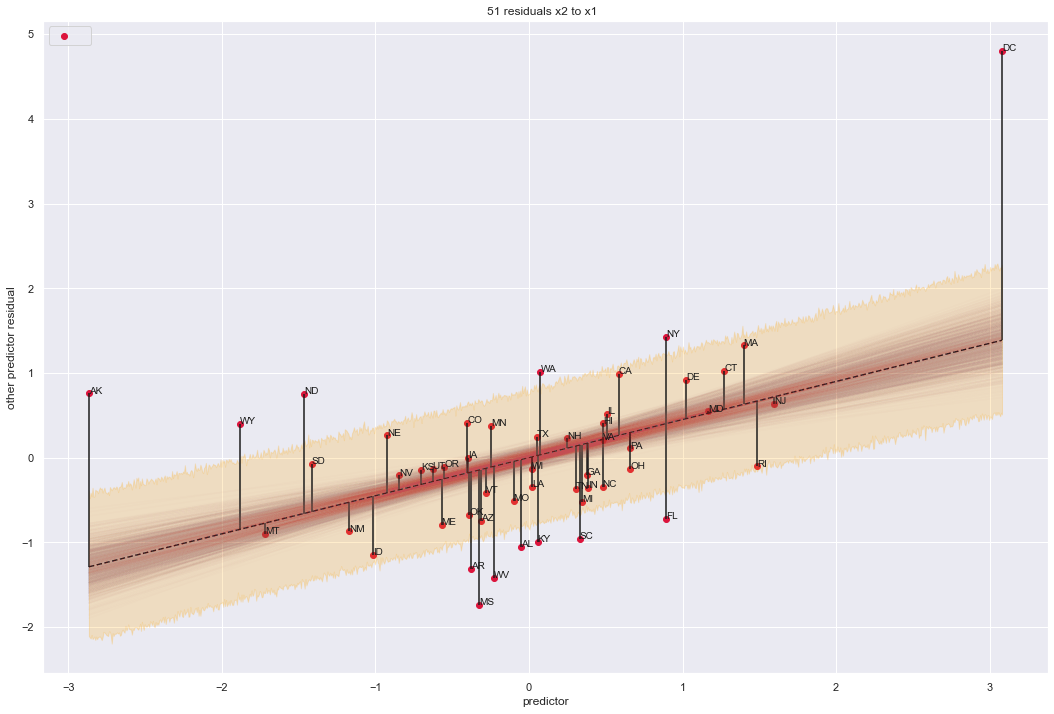

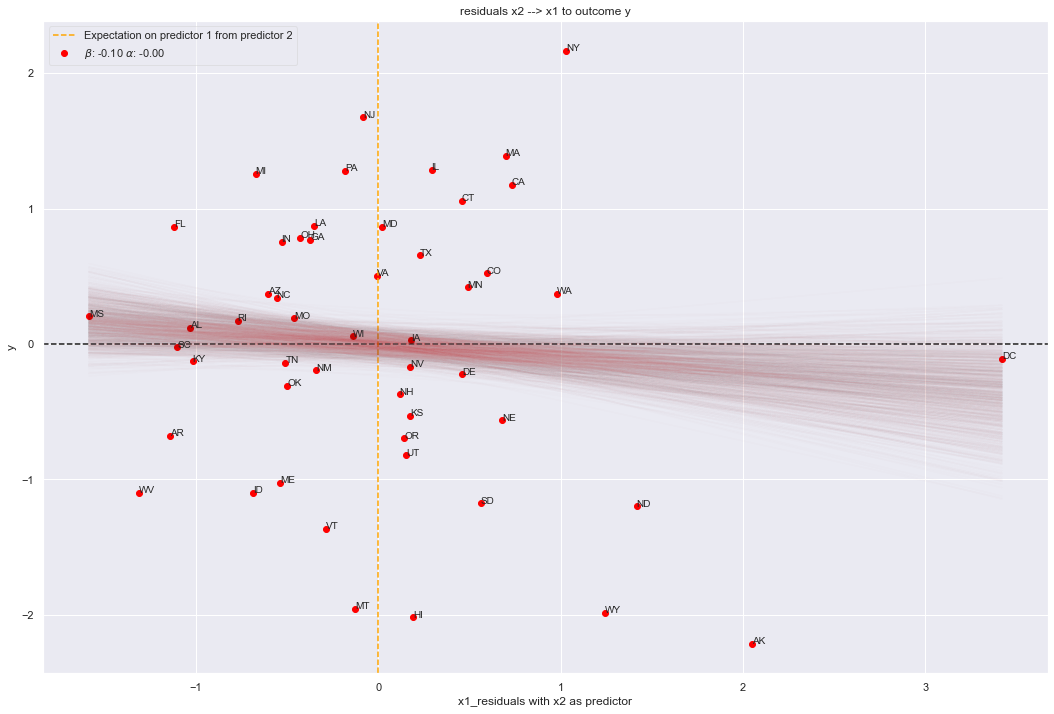

In [19]:
multiple_regression = False


#########
result_x1_x2 = regression(xy['x1_std'],xy['x1_std'],xy['x2_std'])

mean_ys = xy['x1_std'] * result_x1_x2.beta1_post.mean() + result_x1_x2.alpha_post.mean()

low_error = np.zeros_like(xy['x1_std'])
high_error = np.zeros_like(xy['x1_std'])

for i in range(len(low_error)):
    
    if xy['x2_std'].iloc[i] < mean_ys[i]:
        low_error[i] = np.abs(xy['x2_std'].iloc[i] - mean_ys[i])
        high_error[i] = 0
    else:
        high_error[i] = np.abs(xy['x2_std'].iloc[i] - mean_ys[i])
        low_error[i] = 0

residuals_x1_x2 = pd.DataFrame({0 : -1 * low_error + high_error})

if US_states or World_countries:
    residuals_x1_x2.index = xy.index

temp = pd.DataFrame({'predictor': xy['x1_std'],
                    'residual' : residuals_x1_x2[0]})

print()
print (temp.head(50))
print()



result_residuals_x1_x2 = regression(residuals_x1_x2[0],residuals_x1_x2[0], xy['y_std'])

plot(result_x1_x2,xy['x1_std'],xy['x1_std'],xy['x2_std'],
     'residuals x1 to x2',len(xy),xy,create_figure=True,residuals=True,color='g')


plt.errorbar(x=xy['x1_std'],
             y=mean_ys,
             color='k',ls='dashed',fmt='none', yerr= np.array((low_error,high_error)))

plt.savefig('residuals_x1_to_x2.jpg',format='jpg')
           

####
plt.figure(figsize=(18,12))
plt.title('residuals x1 --> x2 regression on outcome y')

plt.scatter(residuals_x1_x2,xy['y_std'],color='g',
            label=r'$\beta$: {:.2f} $\alpha$: {:.2f}'.format(result_residuals_x1_x2.beta1_post.mean(),
                                                            result_residuals_x1_x2.alpha_post.mean()))

plt.axhline(0,color='k',ls='dashed',label='Expectation Outcome')
plt.axvline(0,color='orange',ls='dashed',label='Expectation on predictor 2 from predictor 1')

if US_states or World_countries:
    for s in residuals_x1_x2.index:
        plt.text(residuals_x1_x2.loc[s,0] + 0.001,xy.loc[s,'y_std'] + 0.001,us_abb.loc[s,'abb'])
    
nr_lines = 1000

X = np.linspace(residuals_x1_x2[0].min(),residuals_x1_x2[0].max(),nr_lines)

rows = np.random.choice(result_residuals_x1_x2.index,replace=True,size=nr_lines)

lines = [X[i] * result_residuals_x1_x2.beta1_post[rows] + result_residuals_x1_x2.alpha_post[rows] for i in range(len(X))]


plt.plot(X,lines,alpha=0.01,color='r')  

plt.xlabel('x2_residuals with x1 as predictor')
plt.ylabel('y')

plt.legend(loc='upper left',framealpha=0.4)
plt.savefig('residuals_regression_outcome_plot_x1_x2.jpg',format='jpg')

#########
result_x2_x1 = regression (xy['x2_std'],xy['x2_std'],xy['x1_std'])

mean_ys = xy['x2_std'] * result_x2_x1.beta1_post.mean() + result_x2_x1.alpha_post.mean()

low_error = np.zeros_like(xy['x2_std'])
high_error = np.zeros_like(xy['x2_std'])

for i in range(len(low_error)):
    
    if xy['x1_std'].iloc[i] < mean_ys[i]:
        low_error[i] = np.abs(xy['x1_std'].iloc[i] - mean_ys[i])
        high_error[i] = 0
    else:
        high_error[i] = np.abs(xy['x1_std'].iloc[i] - mean_ys[i])
        low_error[i] = 0

residuals_x2_x1 = pd.DataFrame({0 : -1 * low_error + high_error})

if US_states or World_countries:
    residuals_x2_x1.index = xy.index

temp2 = pd.DataFrame({'predictor': xy['x2_std'],
                    'residual' : residuals_x2_x1[0]})

print()
print (temp2.head(50))
print()


###########################################################################


result_residuals_x2_x1 = regression(residuals_x2_x1[0],residuals_x2_x1[0], xy['y_std'])

plot(result_x2_x1,xy['x2_std'],xy['x2_std'],xy['x1_std'],
     'residuals x2 to x1',len(xy),xy,create_figure=True,residuals=True)


plt.errorbar(x=xy['x2_std'],
             y=mean_ys,
             color='k',ls='dashed',fmt='none', yerr= np.array((low_error,high_error)))

plt.savefig('residuals_x2_to_x1.jpg',format='jpg')

            
####
plt.figure(figsize=(18,12))
plt.title('residuals x2 --> x1 to outcome y')

plt.scatter(residuals_x2_x1,xy['y_std'],color='red',
           label=r'$\beta$: {:.2f} $\alpha$: {:.2f}'.format(result_residuals_x2_x1.beta1_post.mean(),
                                                            result_residuals_x2_x1.alpha_post.mean()))
plt.axhline(0,color='k',ls='dashed')
plt.axvline(0,color='orange',ls='dashed',label='Expectation on predictor 1 from predictor 2')

if US_states or World_countries:
    for s in residuals_x2_x1.index:
        plt.text(residuals_x2_x1.loc[s,0] ,xy.loc[s,'y_std'] ,us_abb.loc[s,'abb'])
    
X = np.linspace(residuals_x2_x1[0].min(),residuals_x2_x1[0].max(),nr_lines)

rows = np.random.choice(result_residuals_x2_x1.index,replace=True,size=nr_lines)

lines = [X[i] * result_residuals_x2_x1.beta1_post[rows] + result_residuals_x2_x1.alpha_post[rows] for i in range(len(X))]

plt.plot(X,lines,alpha=0.01,color='r')  
    
plt.xlabel('x1_residuals with x2 as predictor')
plt.ylabel('y')
plt.legend(loc='upper left',framealpha=0.4)

plt.savefig('residuals_regression_outcome_plot_x2_x1.jpg',format='jpg')

                             0
state                         
Rhode Island          1.530925
New Jersey            1.312384
Florida               1.214560
Maryland              0.921050
District of Columbia  0.920085
Connecticut           0.808503
Massachusetts         0.801607
South Carolina        0.758074
Ohio                  0.717819
North Carolina        0.633077
Delaware              0.610468
Pennsylvania          0.606480
Michigan              0.577787
Indiana               0.544081
Kentucky              0.502311
Tennessee             0.472980
Georgia               0.468870
Mississippi           0.455844
Alabama               0.424770
West Virginia         0.411136
Virginia              0.385701
Hawaii                0.301613
Illinois              0.274022
New York              0.251427
Arkansas              0.211659
Louisiana             0.173445
New Hampshire         0.145910
California            0.137658
Missouri              0.128193
Wisconsin             0.080417
Arizona 

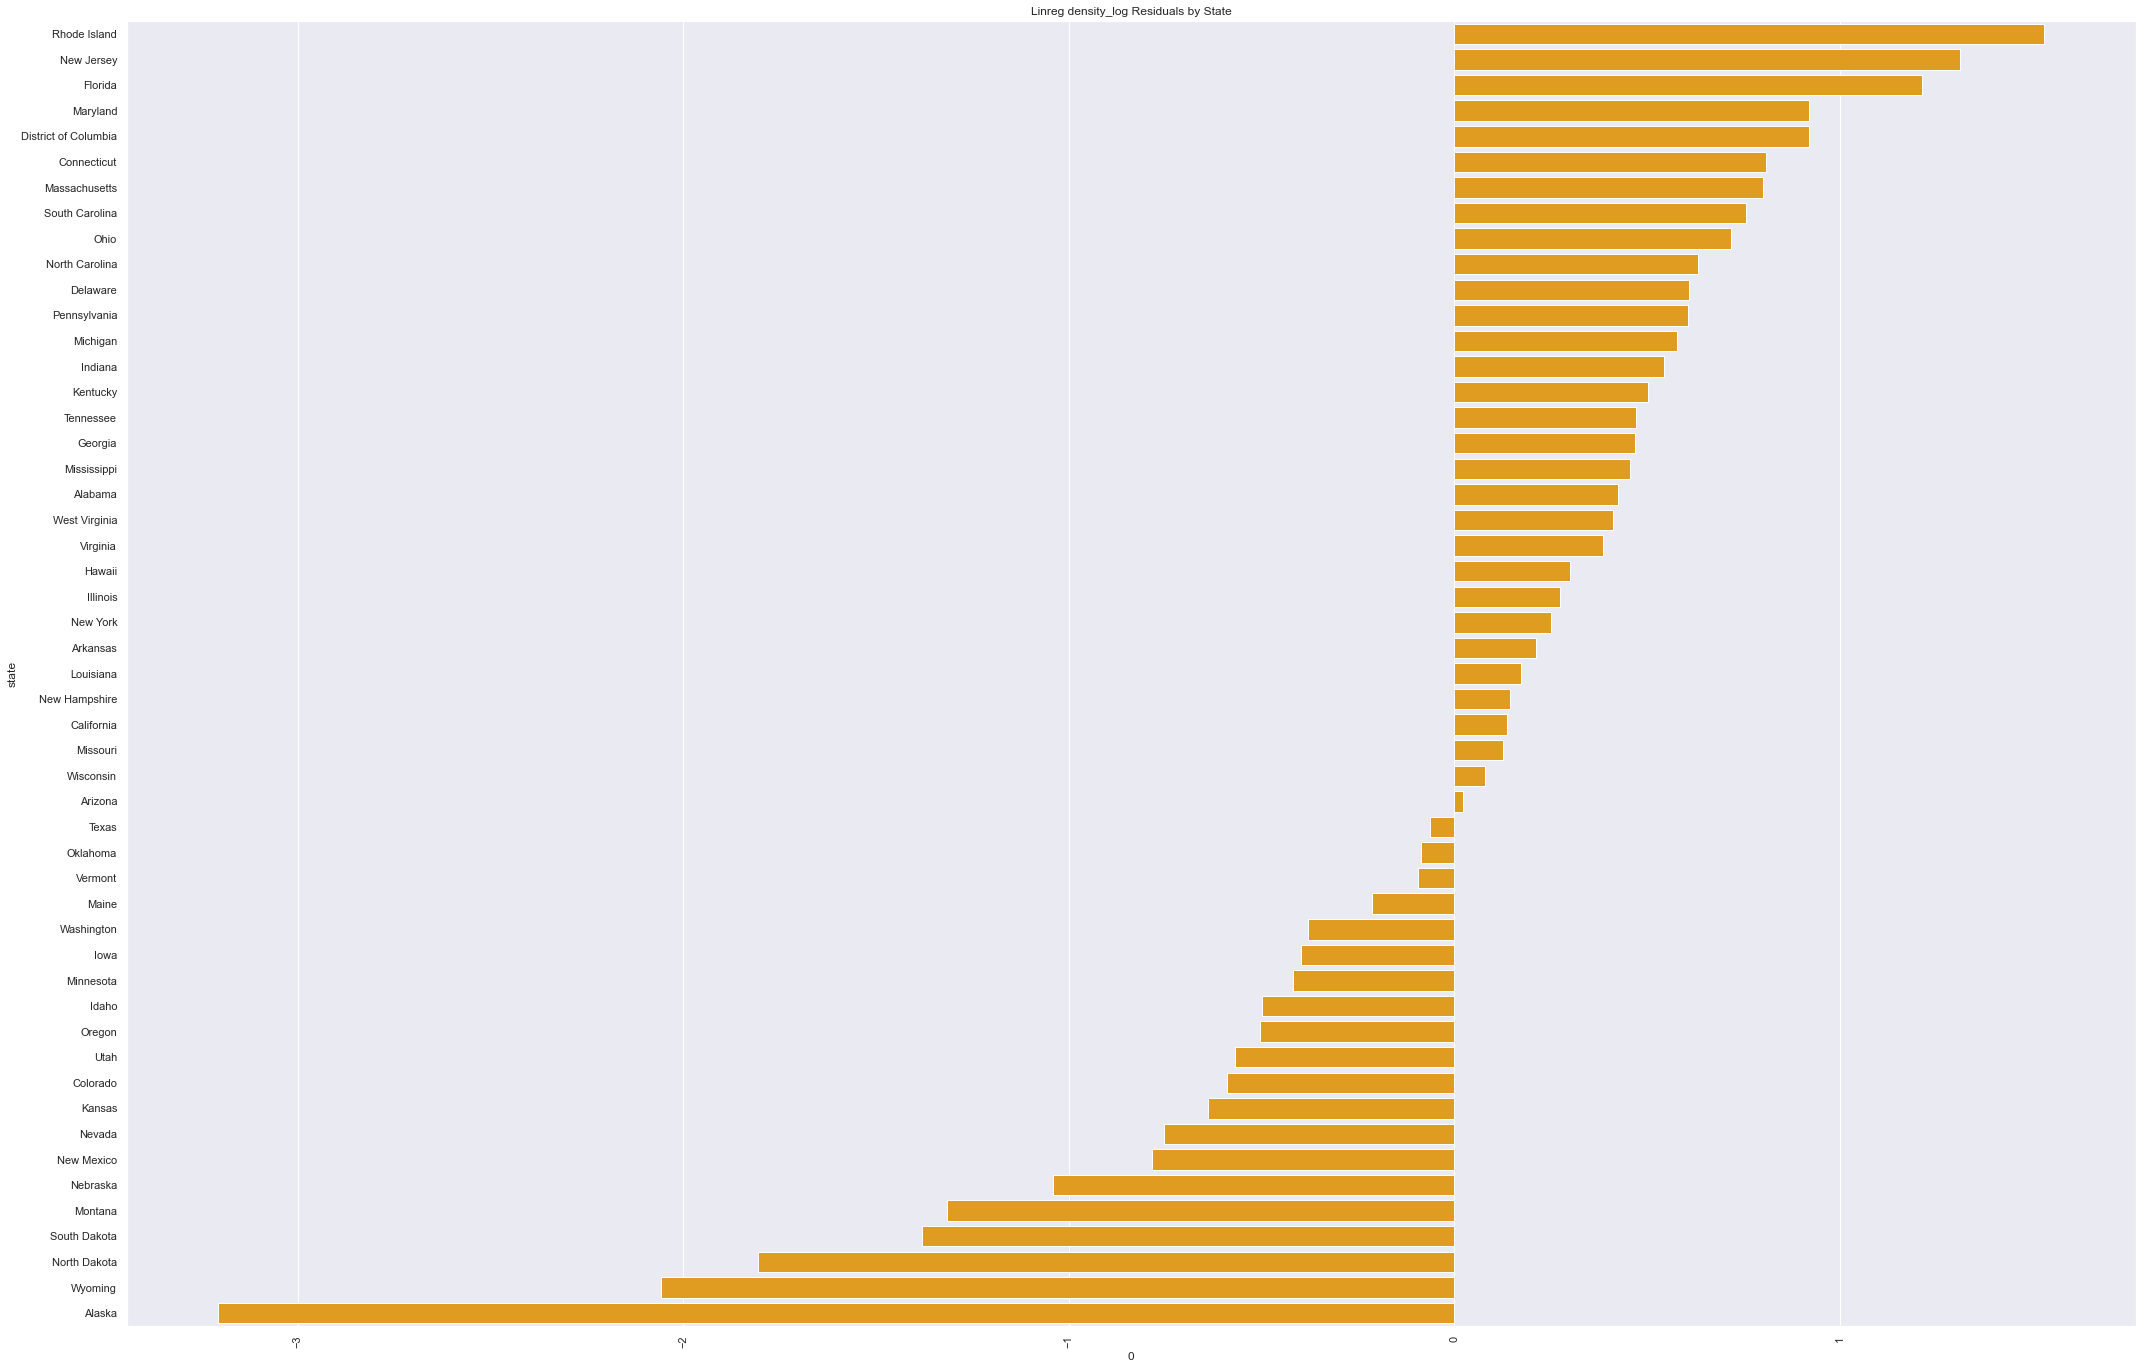

In [20]:
if US_states or World_countries:
    plt.figure(figsize=(36,24))
    plt.title('Linreg {} Residuals by State'.format(x2_param))
    residuals_x1_x2.sort_values(0,inplace=True,ascending=False)
    b = sns.barplot(data=residuals_x1_x2,y=residuals_x1_x2.index,x=0,palette=['orange'])
    plt.xticks(rotation=90)
    plt.savefig('linreg_{}_residuals_by_state.jpg'.format(x2_param))
    print (residuals_x1_x2)

                             0
state                         
Rhode Island          1.530925
New Jersey            1.312384
Florida               1.214560
Maryland              0.921050
District of Columbia  0.920085
Connecticut           0.808503
Massachusetts         0.801607
South Carolina        0.758074
Ohio                  0.717819
North Carolina        0.633077
Delaware              0.610468
Pennsylvania          0.606480
Michigan              0.577787
Indiana               0.544081
Kentucky              0.502311
Tennessee             0.472980
Georgia               0.468870
Mississippi           0.455844
Alabama               0.424770
West Virginia         0.411136
Virginia              0.385701
Hawaii                0.301613
Illinois              0.274022
New York              0.251427
Arkansas              0.211659
Louisiana             0.173445
New Hampshire         0.145910
California            0.137658
Missouri              0.128193
Wisconsin             0.080417
Arizona 

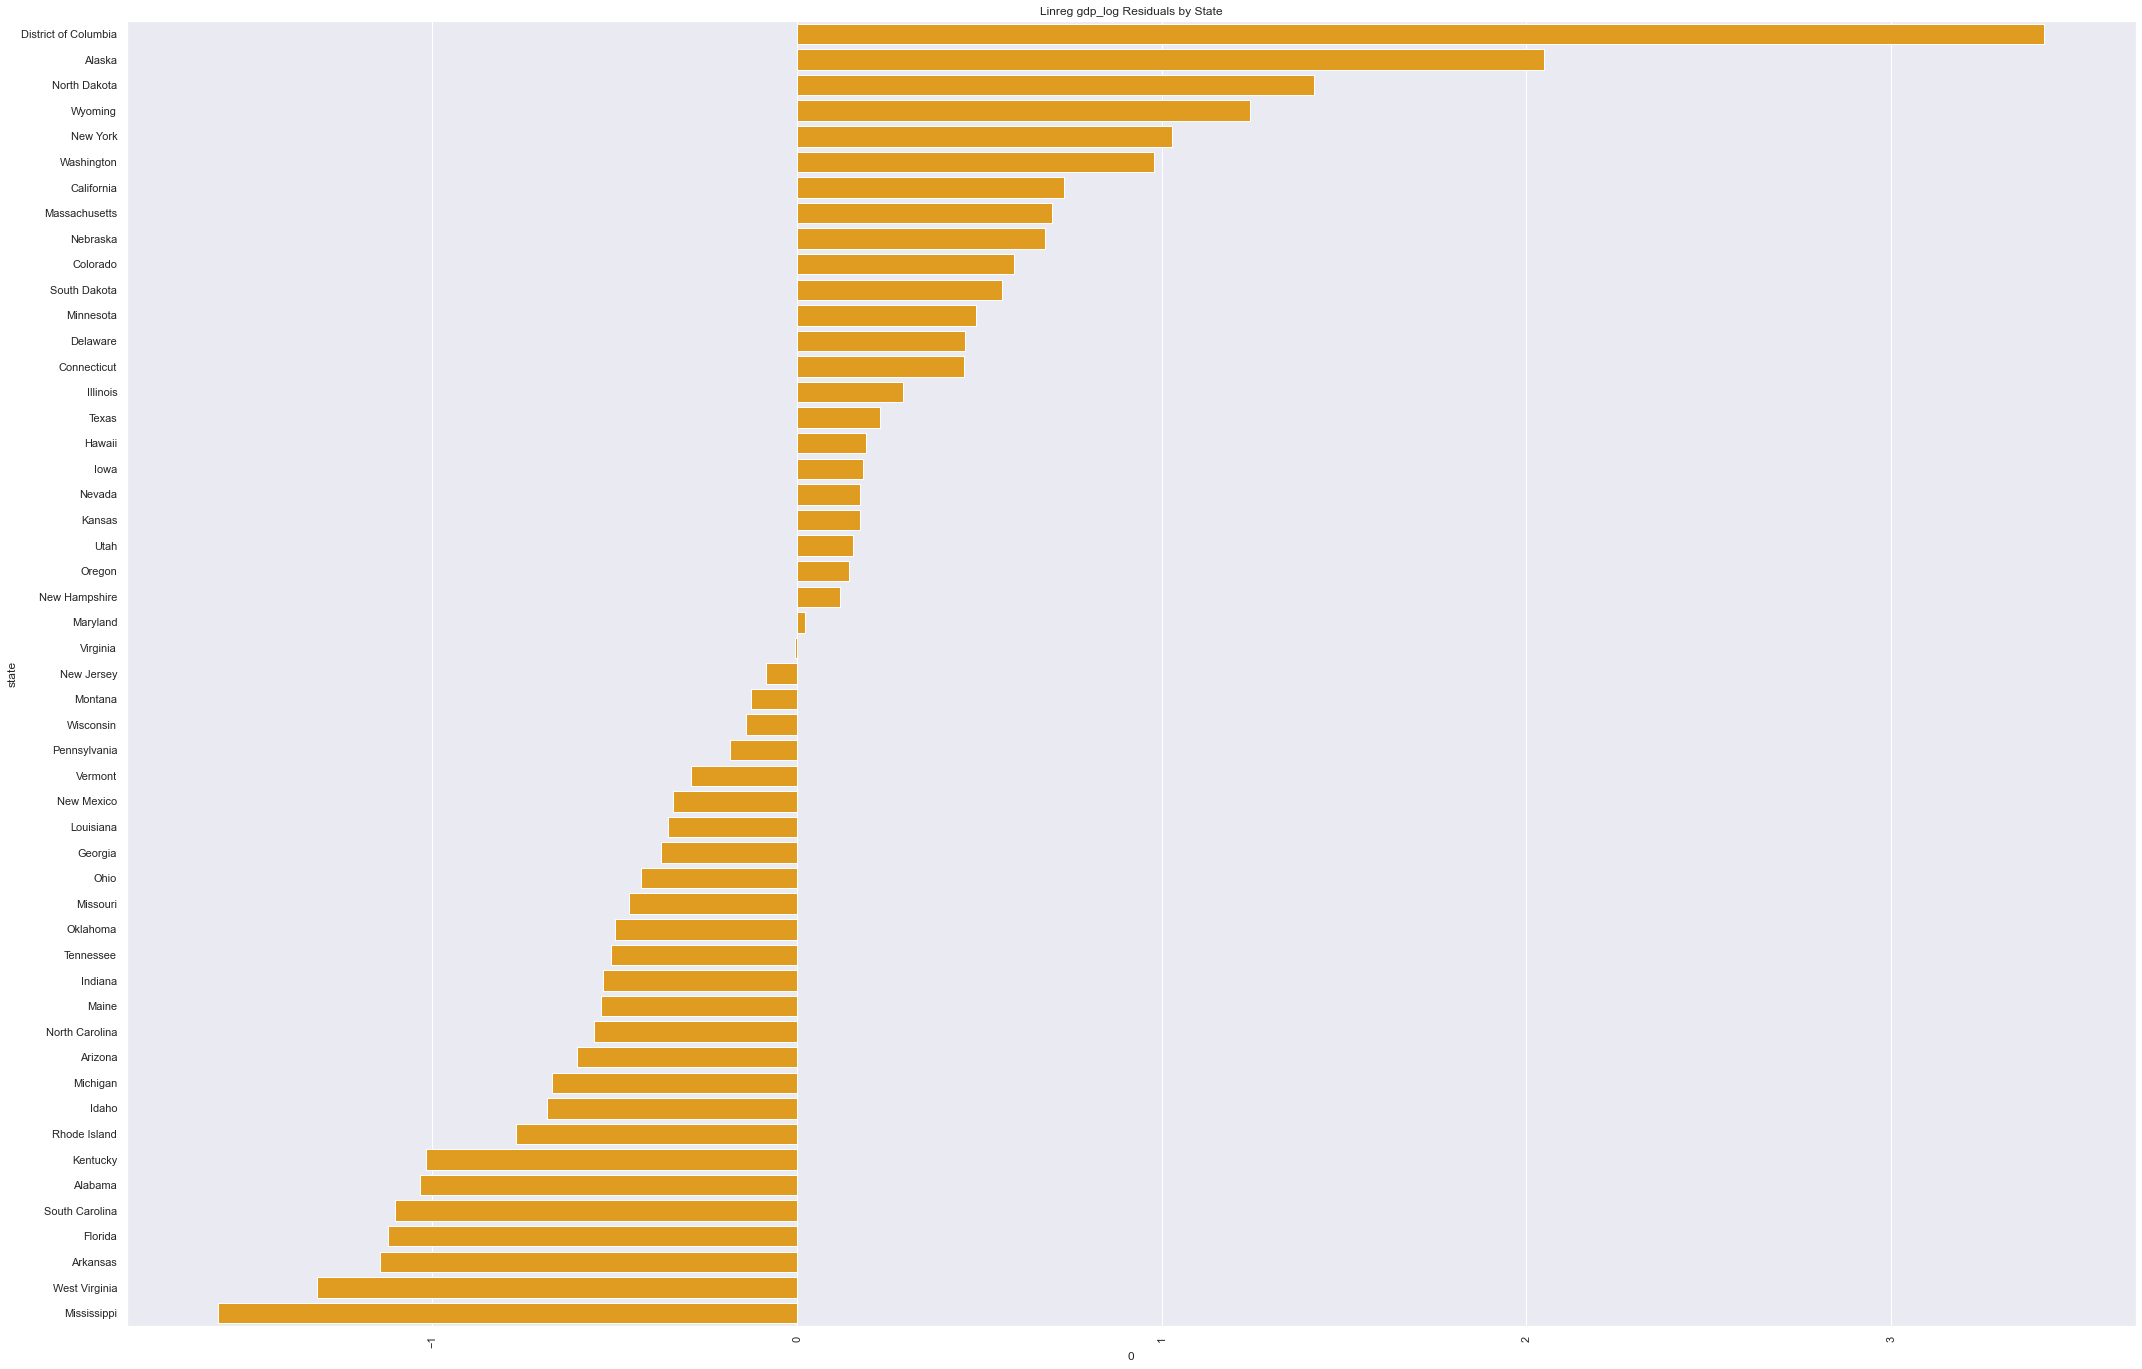

In [21]:
if US_states or World_countries:
    plt.figure(figsize=(36,24))
    plt.title('Linreg {} Residuals by State'.format(x1_param))
    residuals_x2_x1.sort_values(0,inplace=True,ascending=False)
    sns.barplot(data=residuals_x2_x1,y=residuals_x2_x1.index,x=0,palette=['orange'])
    plt.xticks(rotation=90)
    plt.savefig('linreg_{}_residuals_by_state.jpg'.format(x1_param))
    print (residuals_x1_x2)

 [-----------------100%-----------------] 100000 of 100000 complete in 281.8 secPlotting beta1
Plotting beta2


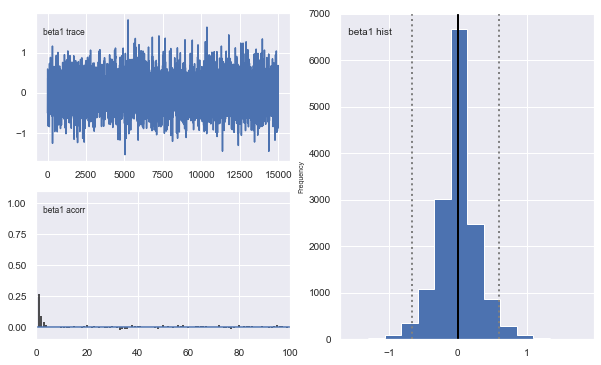

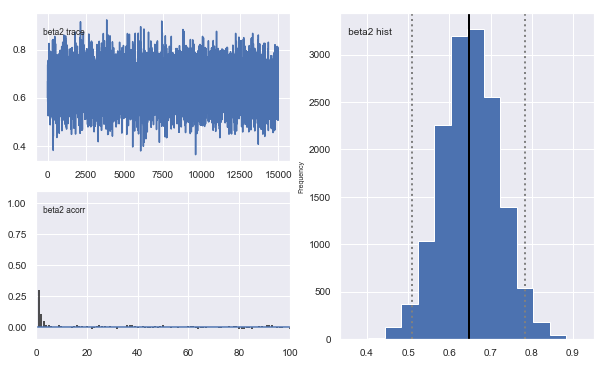

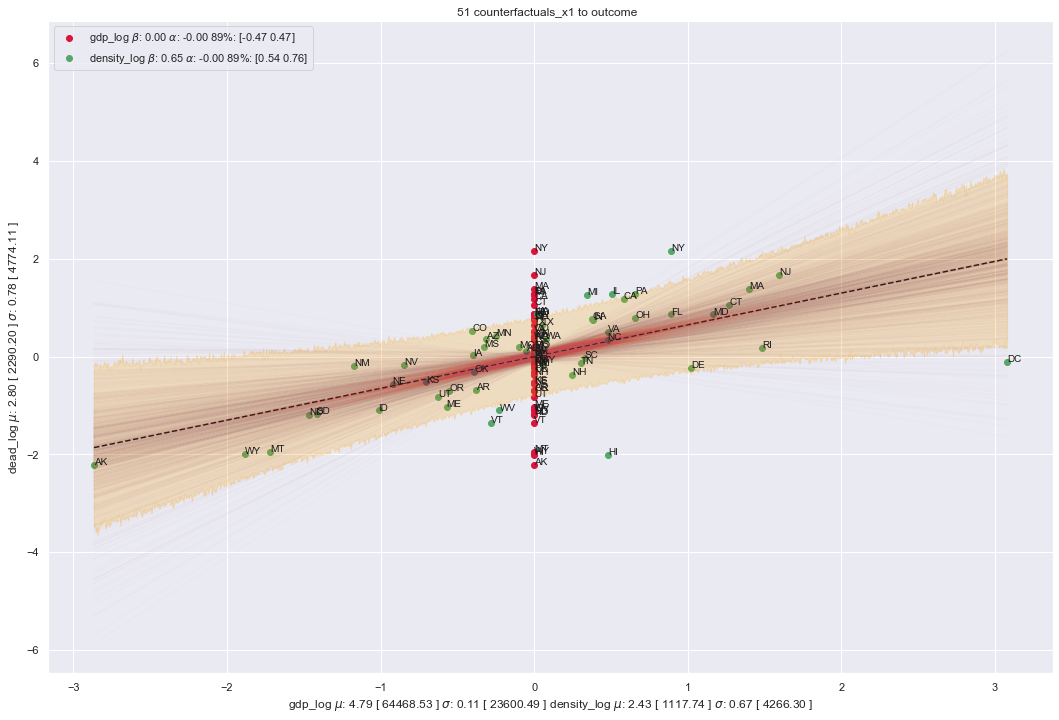

In [22]:
### counterfactual plots

### x1 to mean values
xy['x1_std'] = xy['x1_std'].mean() # array of zeros since we deal with standardized variables

multiple_regression = True
result_counterfactual_x1 = regression(xy['x1_std'], xy['x2_std'],xy['y_std'])

plot(result_counterfactual_x1,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'counterfactuals_x1 to outcome',len(xy),xy,create_figure=True)

 [-----------------100%-----------------] 100000 of 100000 complete in 289.2 secPlotting beta1
Plotting beta2


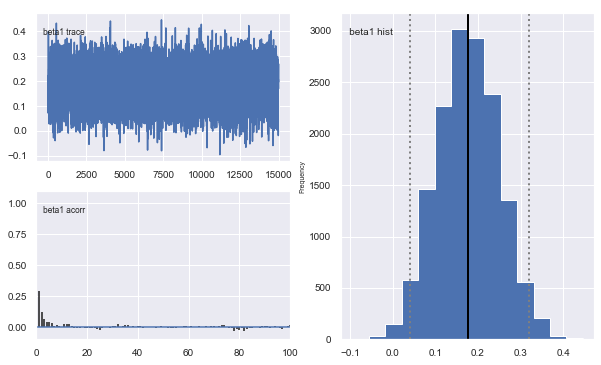

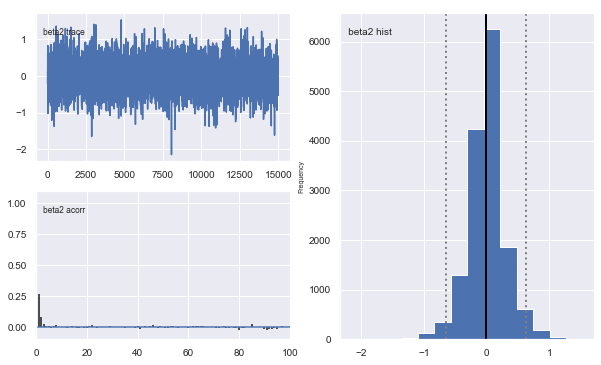

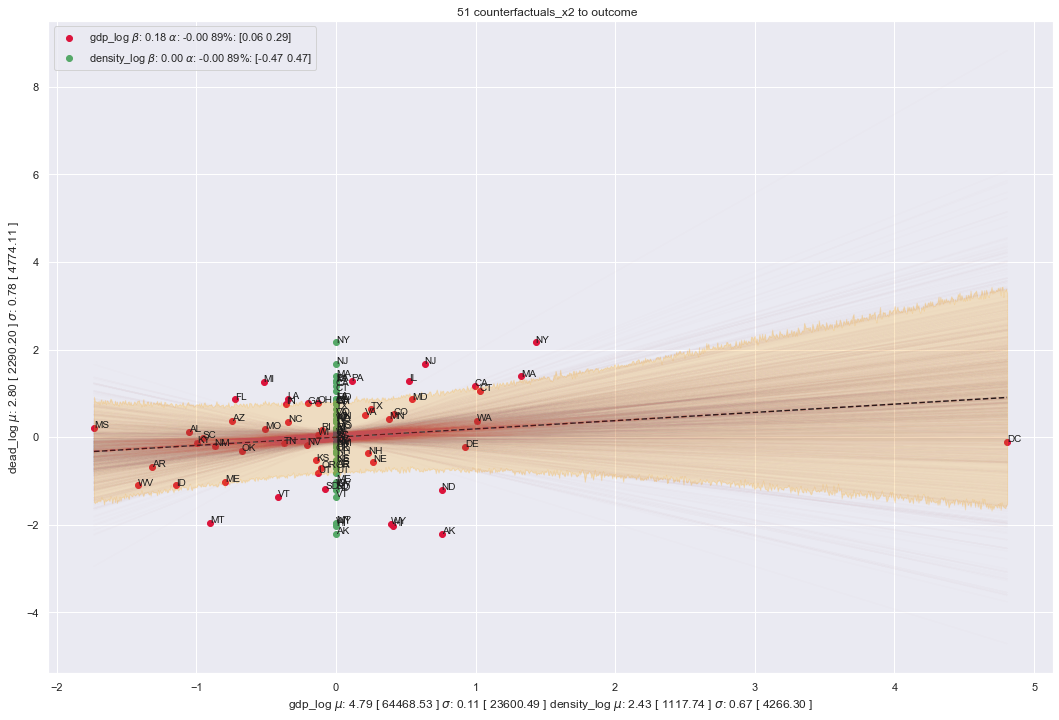

In [23]:
xy = xy_orig.copy()

### x2 to mean values
xy['x2_std'] = xy['x2_std'].mean() # array of zeros since we deal with standardized variables

multiple_regression = True
result_counterfactual_x2 = regression(xy['x1_std'], xy['x2_std'],xy['y_std'])

plot(result_counterfactual_x2,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'counterfactuals_x2 to outcome',len(xy),xy,create_figure=True)



       beta1_mu_post  beta1_sigma_post  beta2_mu_post  beta2_sigma_post  \
8511       -0.028374          0.085836      -0.015355          0.468314   
4771        0.071037          0.168747      -0.023859          0.485984   
11813      -0.048891          0.101573       0.051119          0.495480   
10635       0.009975          0.350068      -0.032795          0.431299   
12344      -0.074319          0.047347      -0.088307          0.368028   
...              ...               ...            ...               ...   
7632       -0.062868          0.024684      -0.008687          0.408310   
13256      -0.092621          0.000585      -0.035520          0.375900   
10871      -0.026160          0.027474       0.064223          0.376316   
8992       -0.095909          0.422410       0.012240          0.407657   
6181       -0.039729          0.461513       0.073711          0.395566   

       obs_sigma_post  alpha_post  beta1_post  beta2_post  
8511         0.483265    0.052490   -0.

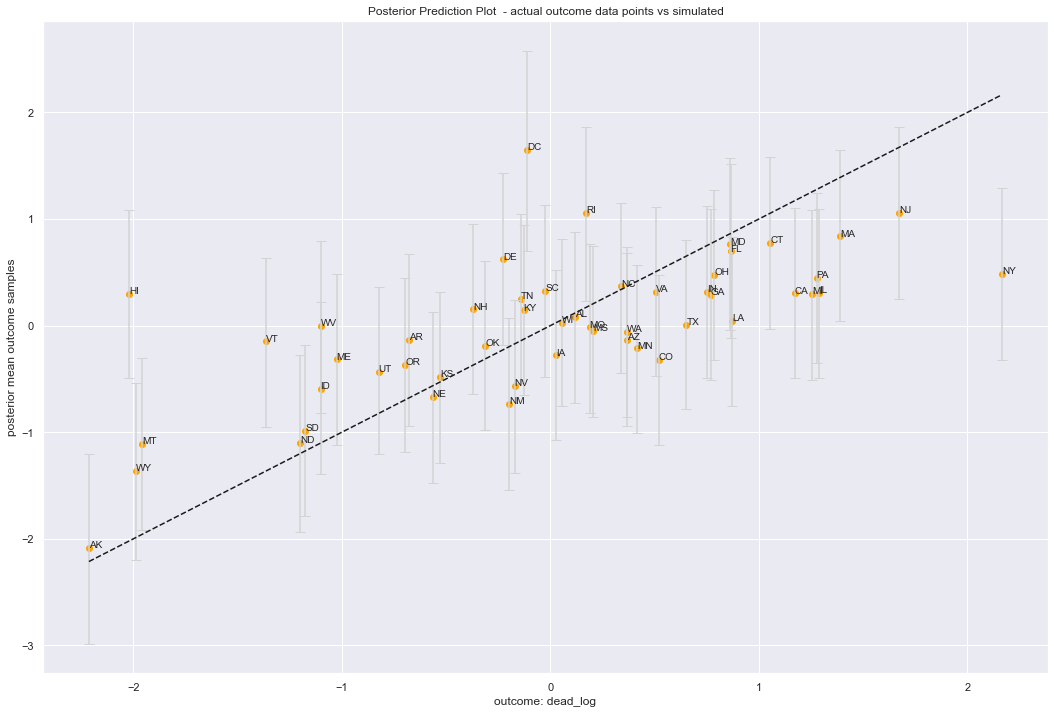

In [24]:
### Posterior prediction plot

xy = xy_orig.copy()

nr_samples = 10000

rows = np.random.choice(result.index,replace=True,size=nr_samples)
samples = result.iloc[rows]
print (samples)

alpha_samples = samples['alpha_post']
beta1_samples = samples['beta1_post']
beta2_samples = samples['beta2_post']
sigma_samples = samples['obs_sigma_post']

X1 = xy['x1_std']
X2 = xy['x2_std']

posterior_samples = np.array([pm.rnormal(X1[i] * beta1_samples + X2[i] * beta2_samples + alpha_samples,
                                        1 / sigma_samples ** 2 ,size=nr_samples) for i in range(len(X1))])

print (posterior_samples.shape)

samples_89 = np.percentile(posterior_samples,[5.5,94.4],axis=1)
print (samples_89.mean(axis=1))
print ()


plt.figure(figsize=(18,12))
plt.title('Posterior Prediction Plot  - actual outcome data points vs simulated')

plt.scatter(xy['y_std'],posterior_samples.mean(axis=1),color='orange')

plt.xlabel('outcome: {}'.format(y_param))
plt.ylabel('posterior mean outcome samples')


plt.errorbar(x=xy['y_std'],
             y=posterior_samples.mean(axis=1),ecolor='lightgrey',capsize=5,
             yerr=np.array((np.abs(posterior_samples.mean(axis=1) - samples_89[0]), 
                            np.abs(posterior_samples.mean(axis=1) - samples_89[1]))),fmt='none')

plt.plot(np.linspace(xy['y_std'].min(),xy['y_std'].max(),100),
         np.linspace(xy['y_std'].min(),xy['y_std'].max(),100),color='k',ls='dashed')


for i,s in enumerate(xy.index):
    plt.text(xy['y_std'].loc[s] ,(posterior_samples.mean(axis=1))[i] ,us_abb.loc[s,'abb'])
    

    
plt.savefig('regression_posterior_plot_{}.jpg'.format(y_param),format='jpg')
    